<a href="https://colab.research.google.com/github/mhdhfzz/data-analyst-dicoding/blob/main/notebook_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Analisis Data: E-Commerce Public Dataset**
- Nama: Muhammad Surya Putra
- Email: muhammadsuryaputra3@gmail.com
- Id Dicoding: muhammadsuryaputra3

## **Defining Business Questions**

- Which products are the best sellers? Is there more profit from inexpensive or expensive products?
- What is the average spending per customer? Does it vary by geographic location?
- Which geographical location has the most customers?


## Preparing Necessary Libraries

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import matplotlib.image as mpimg
from scipy import stats

## **1. Data Wrangling**

### 1.1 Gathering Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Directory containing the CSV files
data_dir = "/content/drive/MyDrive/Colab Notebooks/Data"

# Loading datasets individually (excluding customers and sellers for now)
orders = pd.read_csv(data_dir + '/orders_dataset.csv')
items = pd.read_csv(data_dir + '/order_items_dataset.csv')
products = pd.read_csv(data_dir + '/products_dataset.csv')
payments = pd.read_csv(data_dir + '/order_payments_dataset.csv')
reviews = pd.read_csv(data_dir + '/order_reviews_dataset.csv')
customers = pd.read_csv(data_dir + '/customers_dataset.csv')
sellers = pd.read_csv(data_dir + '/sellers_dataset.csv')
geolocation = pd.read_csv(data_dir + '/geolocation_dataset.csv')
category = pd.read_csv(data_dir + '/product_category_name_translation.csv')

data = {
    'orders': orders,
    'items': items,
    'products': products,
    'payments': payments,
    'reviews': reviews,
    'customers': customers,
    'sellers': sellers,
    'geo': geolocation,
    'category': category
}

Data Inspection

In [8]:
data['customers'].head()
data['geo'].head()
data['items'].head()
data['payments'].head()
data['reviews'].head()
data['orders'].head()
data['products'].head()
data['sellers'].head()
data['category'].head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


### 1.2 Assessing Data
Check Data Types

In [9]:
for df_name, df in data.items():
    print(f'\n{df_name} info:\n')
    df.info()


orders info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

items info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id        

Handle Date Columns

In [10]:
datetime_oo = ["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]
for column in datetime_oo:
    data['orders'][column] = pd.to_datetime(data['orders'][column])

datetime_oi = ["shipping_limit_date"]
for column in datetime_oi:
    data['items'][column] = pd.to_datetime(data['items'][column])

datetime_or = ["review_creation_date","review_answer_timestamp"]
for column in datetime_or:
    data['reviews'][column] = pd.to_datetime(data['reviews'][column])

In [11]:
duplicate_counts = {df_name: df.duplicated().sum() for df_name, df in data.items()}
total_sample_counts = {df_name: len(df) for df_name, df in data.items()}

duplicates_df = pd.DataFrame({
    'Total Sample Count': total_sample_counts,
    'Duplicate Count': duplicate_counts
})
duplicates_df

,Total Sample Count,Duplicate Count
orders,99441,0
items,112650,0
products,32951,0
payments,103886,0
reviews,99224,0
customers,99441,0
sellers,3095,0
geo,1000163,261831
category,71,0


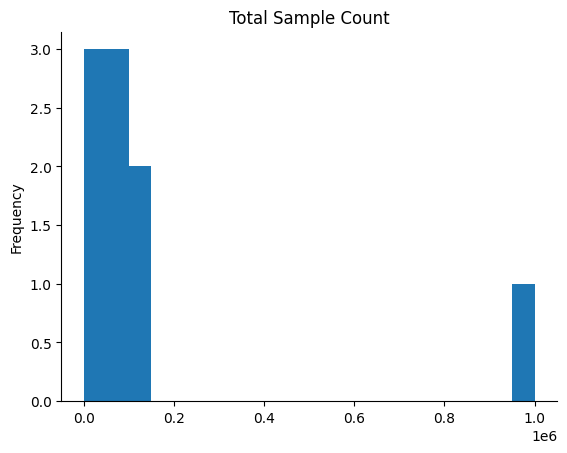

In [14]:
# @title Total Sample Count

from matplotlib import pyplot as plt
duplicates_df['Total Sample Count'].plot(kind='hist', bins=20, title='Total Sample Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

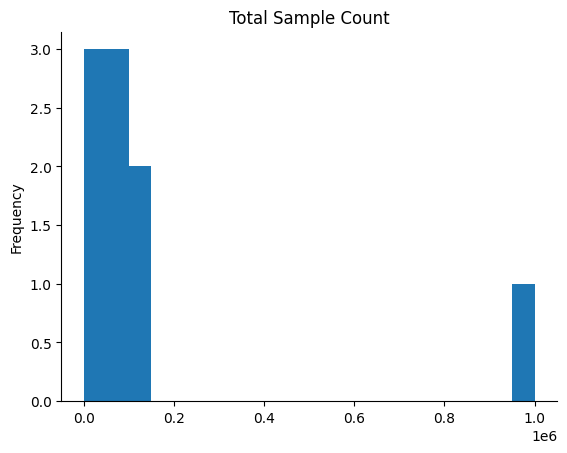

In [13]:
# @title Total Sample Count

from matplotlib import pyplot as plt
duplicates_df['Total Sample Count'].plot(kind='hist', bins=20, title='Total Sample Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
for df_name, df in data.items():
    print(f'{df_name} missing values:\n{df.isna().sum()}\n')

orders missing values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

items missing values:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

products missing values:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

payments missing values:
order_id                0
payment_sequential      0
payment_type            0


### **1.3 Data Cleaning**

1.3.1 Order



*   The orders dataset is crucial as it acts as a connector to many other datasets via order_id.



In [15]:
# Focusing only on delivered orders
delivered_orders = data['orders']['order_id'][data['orders']['order_status'] != 'delivered'].values

# Filtering other datasets where order_id is a foreign key
for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(delivered_orders)].index, inplace=True)

In [16]:
# Dropping orders missing delivery dates
null_deliveries = data['orders']['order_id'][data['orders']['order_delivered_customer_date'].isnull()].values

for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(null_deliveries)].index, inplace=True)

# Creating a new column to indicate if orders were delivered on time
data['orders']['delivered_on_time'] = np.where(data['orders']['order_delivered_customer_date'] < data['orders']['order_estimated_delivery_date'], 'On Time', 'Late')


In [17]:
# Dropping the review_comment_title column due to high percentage of NaN values
data['reviews'].drop(columns=['review_comment_title'], inplace=True)

# Replacing NaN values in review_comment_message with 0 (assuming no review left)
data['reviews']['review_comment_message'] = np.where(data['reviews']['review_comment_message'].isnull(), 0, 1)


In [18]:
# Dropping unnecessary columns with too many NaN values
data['products'].drop(columns=['product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

# Filling NaN values in product_category_name with 'other'
data['products']['product_category_name'].fillna('other', inplace=True)

# Filling NaN values in product_photos_qty with 0
data['products']['product_photos_qty'].fillna(0, inplace=True)


In [19]:
# Removing duplicate rows
data['geo'].drop_duplicates(inplace=True)

## **2. Exploratory Data Analysis (EDA)**

### 2.1 Explore customers

In [20]:
data['customers'].sample(5)
data['customers'].groupby('customer_city').customer_id.nunique().sort_values(ascending=False)
data['customers'].groupby('customer_state').customer_id.nunique().sort_values(ascending=False)


customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_id, dtype: int64

In [21]:
data['payments'].sample(5)
data['payments'].groupby('payment_type').order_id.nunique().sort_values(ascending=False)


payment_type
credit_card    74297
boleto         19191
voucher         3679
debit_card      1484
Name: order_id, dtype: int64

### 2.3 Explore orders

In [22]:
data['orders'].sample(5)
data['orders']['delivered_on_time'].describe()


count       96470
unique          2
top       On Time
freq        88644
Name: delivered_on_time, dtype: object

### 2.4 Merging Data for Analysis

*   Customers & Orders

In [23]:
customers_orders_df = pd.merge(data['customers'], data['orders'], on='customer_id', how='left')
customers_orders_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_on_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,On Time
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,On Time
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,Late
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,On Time
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,On Time


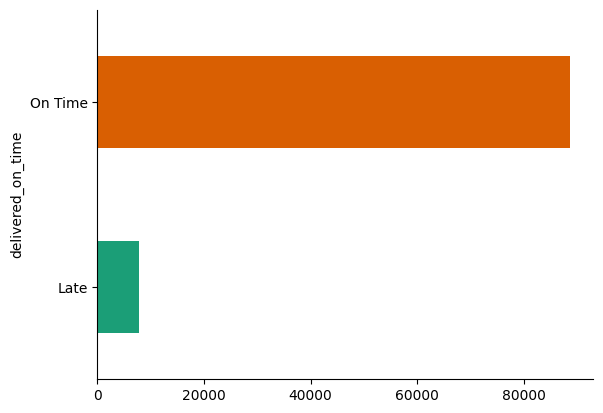

In [26]:
# @title delivered_on_time

from matplotlib import pyplot as plt
import seaborn as sns
customers_orders_df.groupby('delivered_on_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

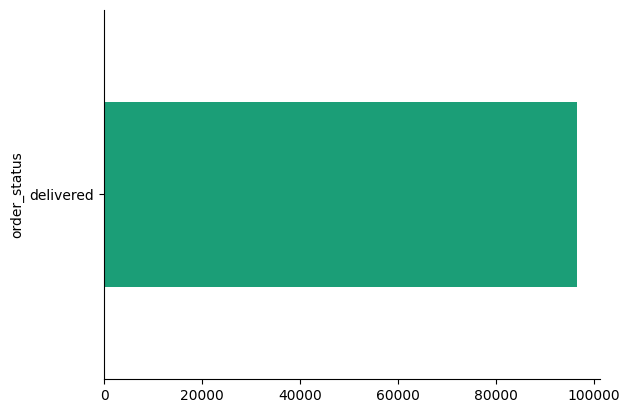

In [25]:
# @title order_status

from matplotlib import pyplot as plt
import seaborn as sns
customers_orders_df.groupby('order_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

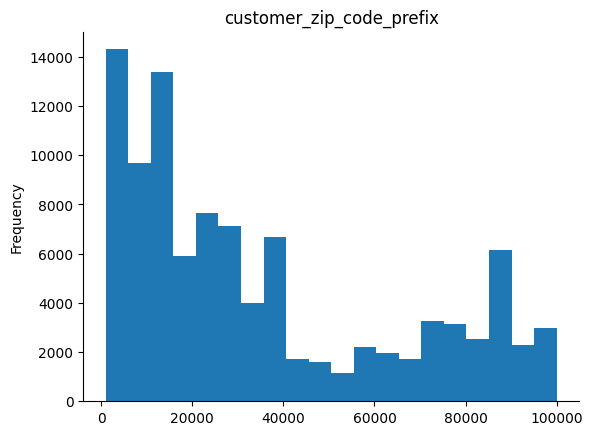

In [24]:
# @title customer_zip_code_prefix

from matplotlib import pyplot as plt
customers_orders_df['customer_zip_code_prefix'].plot(kind='hist', bins=20, title='customer_zip_code_prefix')
plt.gca().spines[['top', 'right',]].set_visible(False)

*   Payments & Reviews

In [30]:
payments_reviews_df = pd.merge(data['payments'], data['reviews'], on='order_id', how='left')
payments_reviews_df.head()


,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,4ce650e117a5b292bf5ea980a61eb61e,1.0,1.0,2018-05-10,2018-05-15 23:38:00
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,ad2036caca61484fc435d7e673c020f2,5.0,0.0,2018-06-30,2018-07-03 11:23:16
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,bcddfa0f7d2e54cfc74bae4f01b84d92,5.0,1.0,2017-12-19,2017-12-22 17:55:30
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,c37a0e51e5df82bdb55d38ff0ffb6af3,5.0,0.0,2017-12-21,2017-12-21 21:42:31
4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,5bc7680443b4ef765fec11a8201eeb0c,5.0,0.0,2017-12-21,2017-12-22 01:10:39


*  Combining Customers, Orders, Payments, and Review

In [31]:
customers_df = pd.merge(customers_orders_df, payments_reviews_df, on='order_id', how='left')
customers_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,delivered_on_time,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,On Time,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,0.0,2017-05-26,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,On Time,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,0.0,2018-01-30,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,Late,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,0.0,2018-06-15,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,On Time,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,0.0,2018-03-29,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,On Time,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,2018-08-10,2018-08-17 01:59:52


*   Items & Sellers

In [32]:
item_seller_df = pd.merge(data['items'], data['sellers'], on='seller_id', how='left')
item_seller_df.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR


 Products & Categories

In [33]:
product_df = pd.merge(data['products'], data['category'], on='product_category_name', how='left')
product_df.head()


,product_id,product_category_name,product_photos_qty,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,1.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,1.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,4.0,housewares


Merging Items, Sellers, and Products

In [34]:
sellers_df = pd.merge(product_df, item_seller_df, on='product_id', how='left')
sellers_df.head()


,product_id,product_category_name,product_photos_qty,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,1.0,perfumery,e17e4f88e31525f7deef66779844ddce,1.0,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,3694.0,sao paulo,SP
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1.0,art,5236307716393b7114b53ee991f36956,1.0,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,2955.0,sao paulo,SP
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,1.0,sports_leisure,01f66e58769f84129811d43eefd187fb,1.0,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,2016.0,sao paulo,SP
3,cef67bcfe19066a932b7673e239eb23d,bebes,1.0,baby,143d00a4f2dde4e0364ee1821577adb3,1.0,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,13330.0,indaiatuba,SP
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,4.0,housewares,86cafb8794cb99a9b1b77fc8e48fbbbb,1.0,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,4461.0,sao paulo,SP


### 2.5 Geolocation

In [35]:
data['geo'].sample(5)
data['geo'].groupby('geolocation_zip_code_prefix').size().sort_values(ascending=False)


geolocation_zip_code_prefix
38400    779
35500    751
11680    727
11740    678
36400    627
        ... 
85571      1
85579      1
4479       1
85138      1
84608      1
Length: 19015, dtype: int64

*   Combining All Data


In [36]:
all_data = pd.merge(customers_df, sellers_df, on='order_id', how='left')
all_data_df = all_data.drop_duplicates('order_id')
all_data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 96471 entries, 0 to 2305341
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96471 non-null  object        
 1   customer_unique_id             96471 non-null  object        
 2   customer_zip_code_prefix       96471 non-null  int64         
 3   customer_city                  96471 non-null  object        
 4   customer_state                 96471 non-null  object        
 5   order_id                       96470 non-null  object        
 6   order_status                   96470 non-null  object        
 7   order_purchase_timestamp       96470 non-null  datetime64[ns]
 8   order_approved_at              96456 non-null  datetime64[ns]
 9   order_delivered_carrier_date   96469 non-null  datetime64[ns]
 10  order_delivered_customer_date  96470 non-null  datetime64[ns]
 11  order_estimated_de

In [37]:
all_data_df.groupby('customer_state').agg({
    'order_id': 'nunique',
    'payment_value': 'sum'
}).sort_values(by='payment_value', ascending=False)

all_data_df.groupby('product_category_name_english').agg({
    'order_id': 'nunique',
    'review_score': ['min', 'max']
})


order_id review_score     
                               nunique          min  max
product_category_name_english                           
agro_industry_and_commerce         177          1.0  5.0
air_conditioning                   244          1.0  5.0
art                                191          1.0  5.0
arts_and_craftmanship               22          1.0  5.0
audio                              345          1.0  5.0
...                                ...          ...  ...
stationery                        2252          1.0  5.0
tablets_printing_image              79          1.0  5.0
telephony                         4078          1.0  5.0
toys                              3774          1.0  5.0
watches_gifts                     5472          1.0  5.0

[71 rows x 3 columns]

In [39]:
# Specify the path where to save the CSV file
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/Data/df.csv"

# Save the all_data to a CSV file
all_data_df.to_csv(output_csv_path, index=False)

## **3. Visualization & Explanatory Analysis**

###3.1 Best Selling Products and Profit Analysis

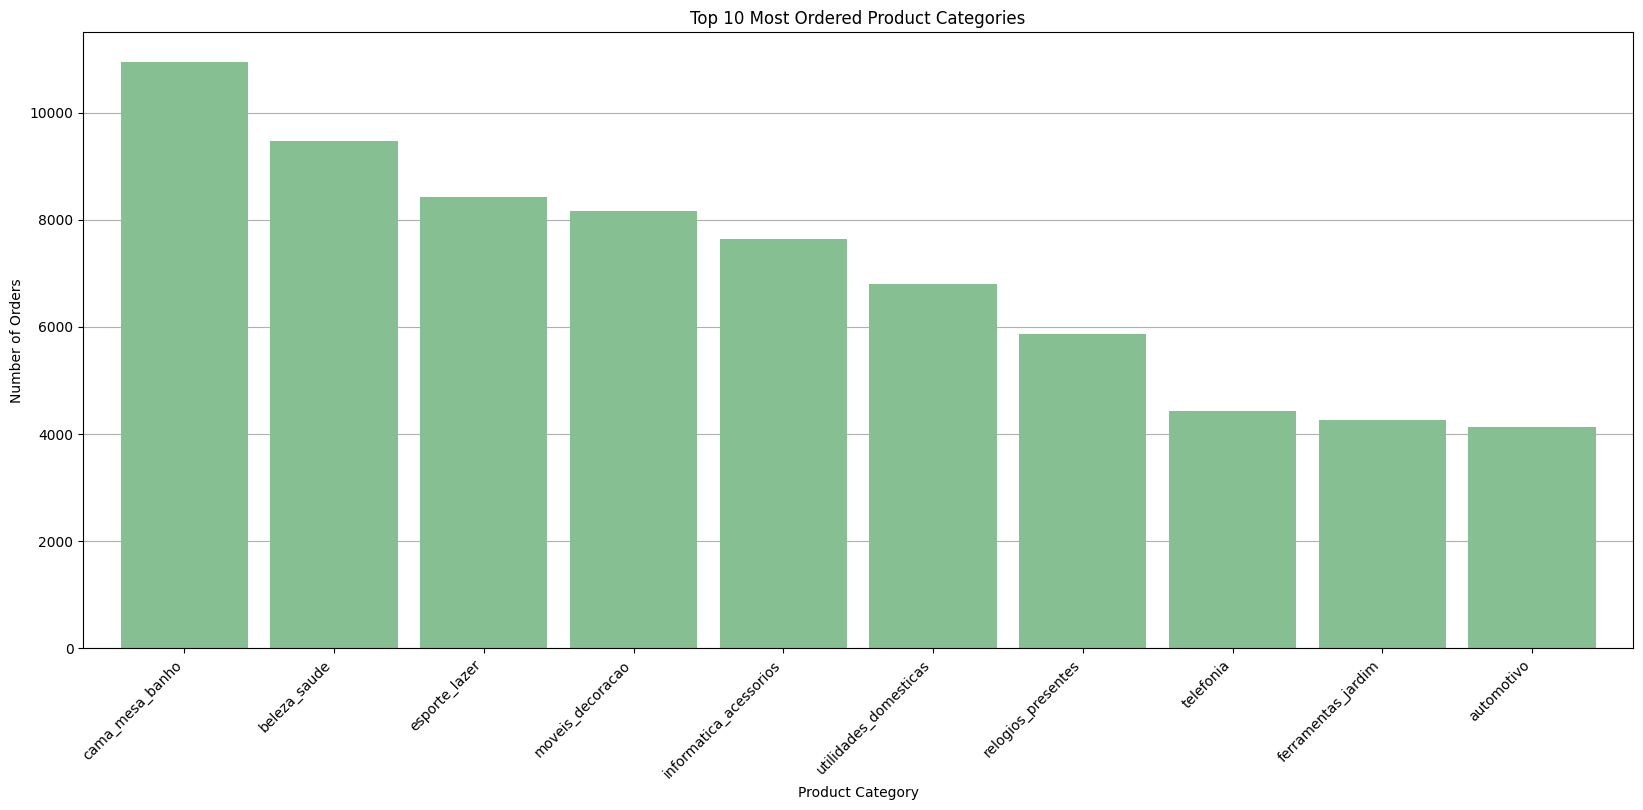

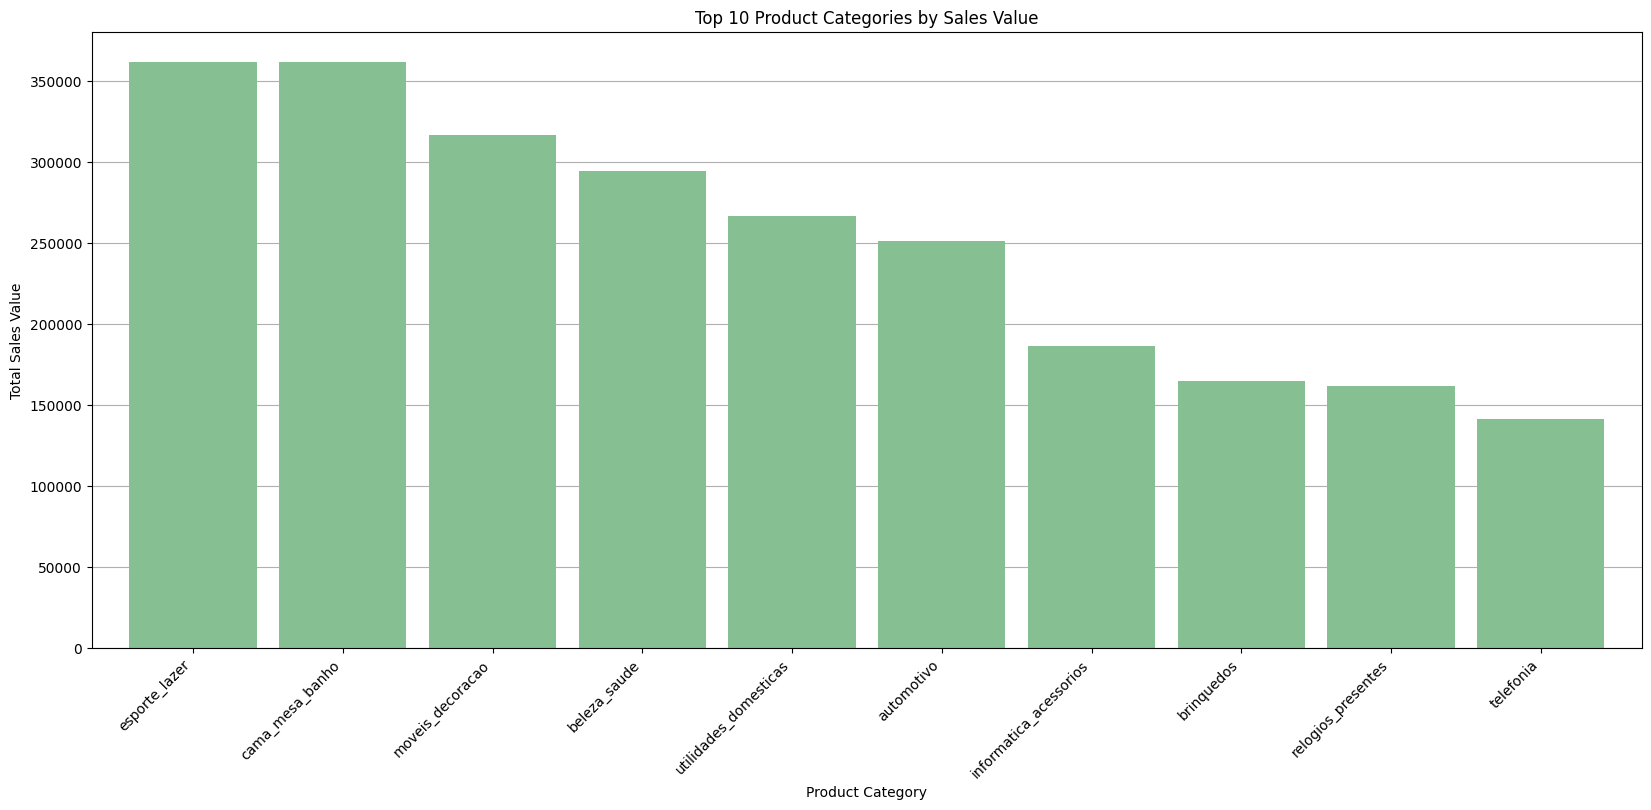

In [40]:
# Merging products dataset with items dataset
items_product = data['items'].merge(data['products'], on='product_id', how='inner')
orders_ip = data['orders'].merge(items_product, on='order_id', how='inner')

# Grouping by product category to get the order count
categories_by_orders = orders_ip['product_category_name'].value_counts()
categories_by_orders[:10].plot(kind='bar', figsize=(20, 8), color='#86bf91', zorder=2, width=0.85)
plt.title('Top 10 Most Ordered Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(True, axis='y')
plt.show()

# Calculating total sales value for each product category
products['total'] = items_product['price'] * items_product['order_item_id']
categories_by_sales = products.groupby('product_category_name').total.sum().sort_values(ascending=False)
categories_by_sales[:10].plot(kind='bar', figsize=(20, 8), color='#86bf91', zorder=2, width=0.85)
plt.title('Top 10 Product Categories by Sales Value')
plt.xlabel('Product Category')
plt.ylabel('Total Sales Value')
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(True, axis='y')
plt.show()


### 3.2 Average Customer Spend by State

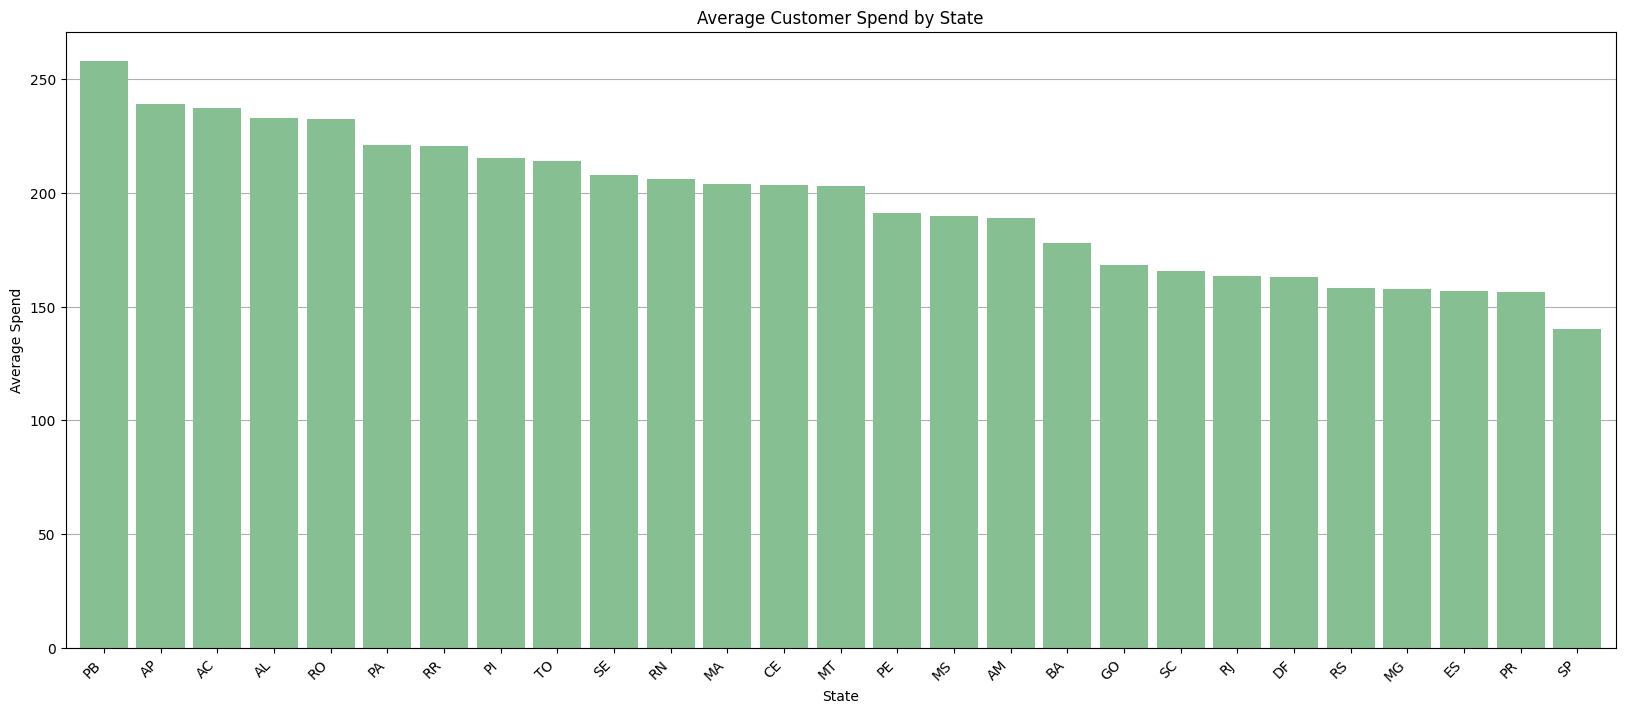

In [41]:
avg_spend_by_state = all_data_df.groupby('customer_state')['payment_value'].mean().sort_values(ascending=False)
avg_spend_by_state.plot(kind='bar', figsize=(20, 8), color='#86bf91', zorder=2, width=0.85)
plt.title('Average Customer Spend by State')
plt.xlabel('State')
plt.ylabel('Average Spend')
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(True, axis='y')
plt.show()


### 3.3 Customer Distribution by State


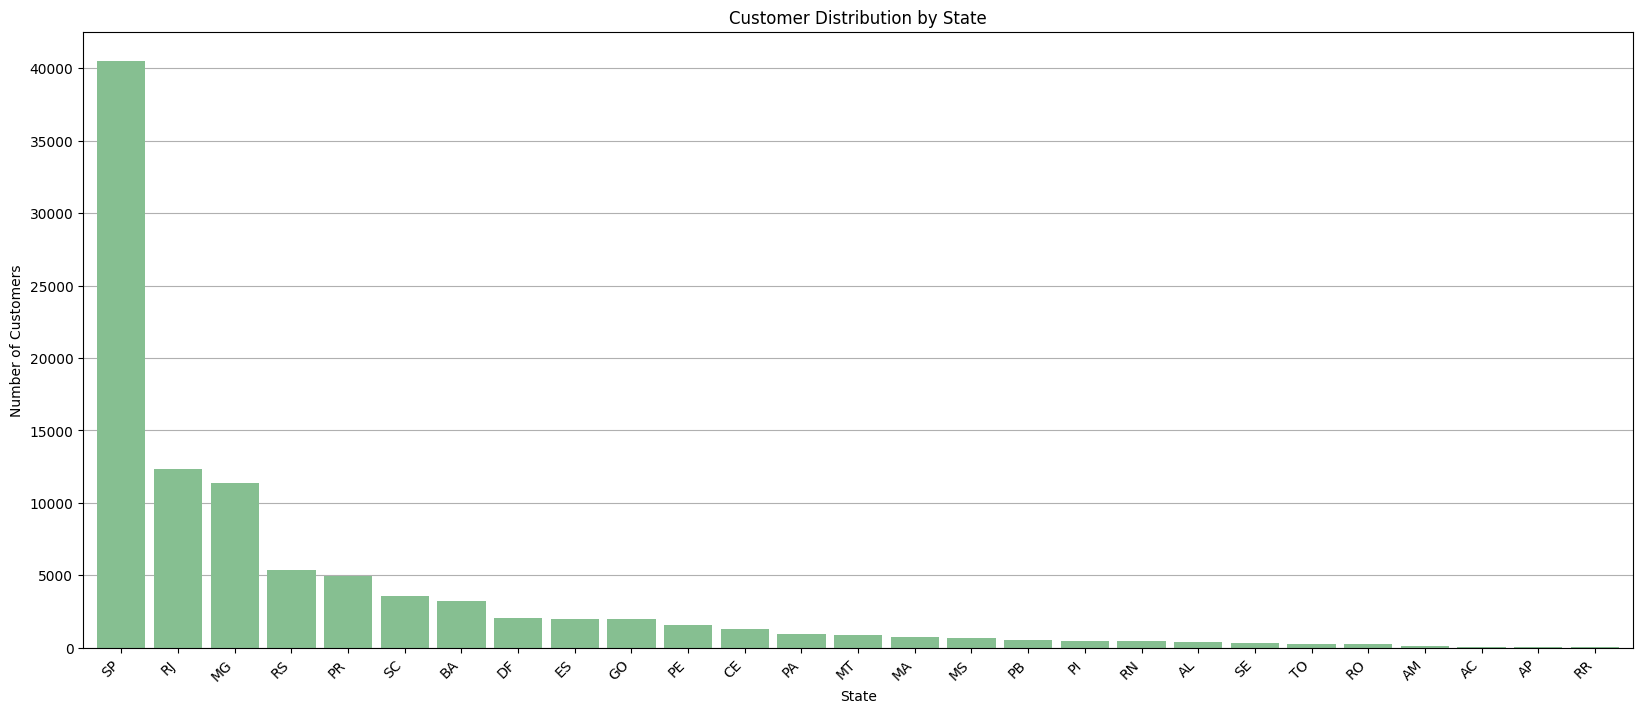

In [42]:
customer_count_by_state = all_data_df['customer_state'].value_counts().sort_values(ascending=False)
customer_count_by_state.plot(kind='bar', figsize=(20, 8), color='#86bf91', zorder=2, width=0.85)
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(True, axis='y')
plt.show()


### 3.4 Customer Loyalty Analysis

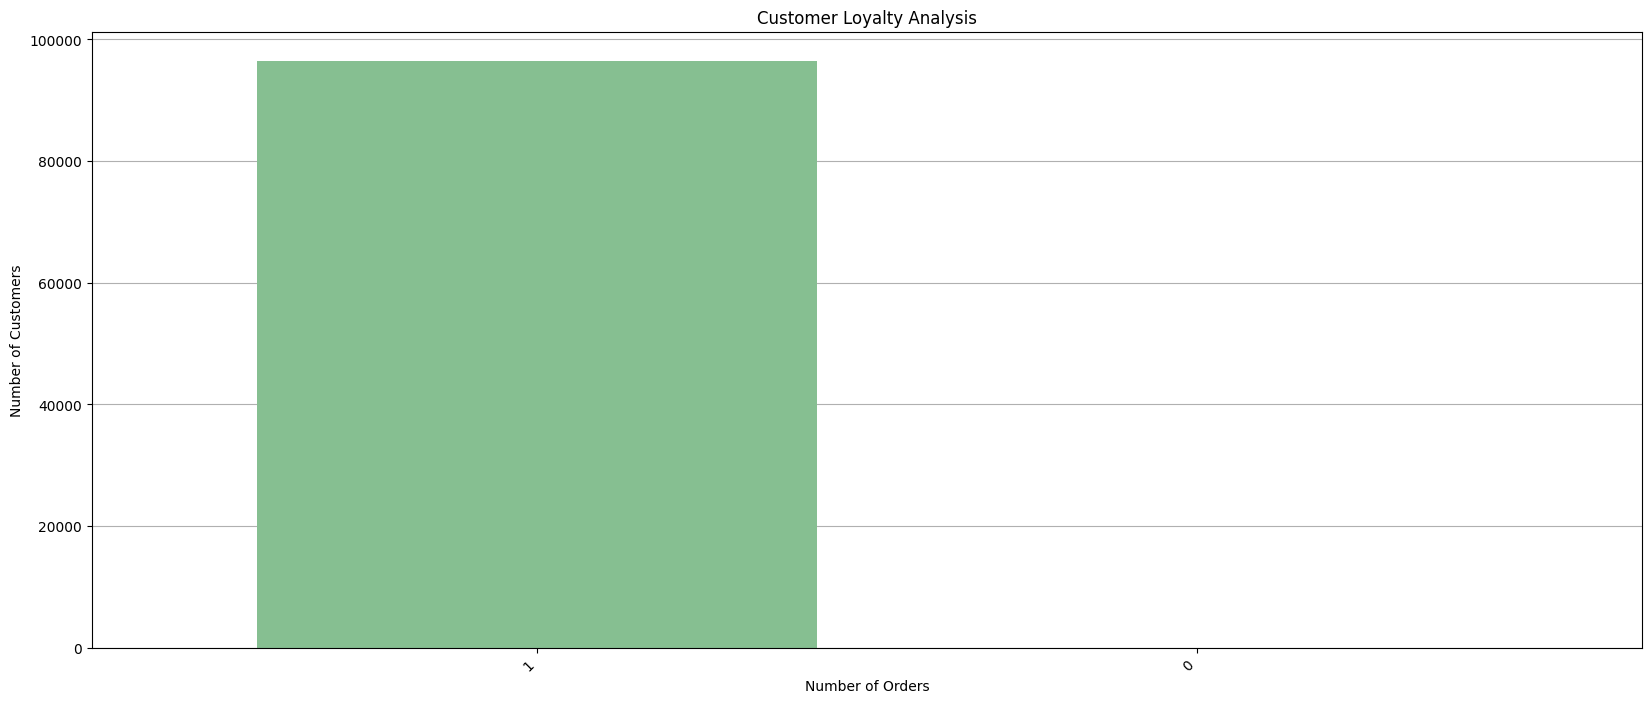

In [43]:
customer_orders = all_data_df.groupby('customer_id')['order_id'].count().value_counts()
customer_orders.plot(kind='bar', figsize=(20, 8), color='#86bf91', zorder=2, width=0.85)
plt.title('Customer Loyalty Analysis')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(True, axis='y')
plt.show()


### 3.5 Geolocation

                         customer_id                customer_unique_id  \
0   06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1   5dca924cc99eea2dc5ba40d11ec5dd0f  2761fee7f378f0a8d7682d8a3fa07ab1   
2   661897d4968f1b59bfff74c7eb2eb4fc  d06a495406b79cb8203ea21cc0942f8c   
3   702b62324327ccba20f1be3465426437  8b3d988f330c1d1c3332ccd440c147b7   
4   bdf997bae7ca819b0415f5174d6b4302  866755e25db620f8d7e81b351a15bb2f   
5   48a9965057e1c75ed3a4d511714be18b  2be1bf7d96bccea9775dcd4c5cbde376   
6   96fbbe8005e67d382b0fc453a288be02  8d153d12b59d763efeb3953822c51862   
7   7d58157ef9ab184d29d36f009c7ad786  4dd678b3eb5be4a5589f5566ec386e09   
8   d3c09791fc7ede919353f0488a3375a6  422b5643b144b86f0168965efd90c219   
9   29e139325c0dac2e5a95c165699b68c3  d0fa1eaf9648a765ed0458e85186703d   
10  381453d9d27041020ea9f7dbb9ecbcca  b2f6d1a1efef637d37b0654fdb259716   
11  85db3d57353cb12f8ccf1140ea473082  6741fe058b7a7605920b9060b234294e   
12  e2742ef931c3e60509e74345605c5370  

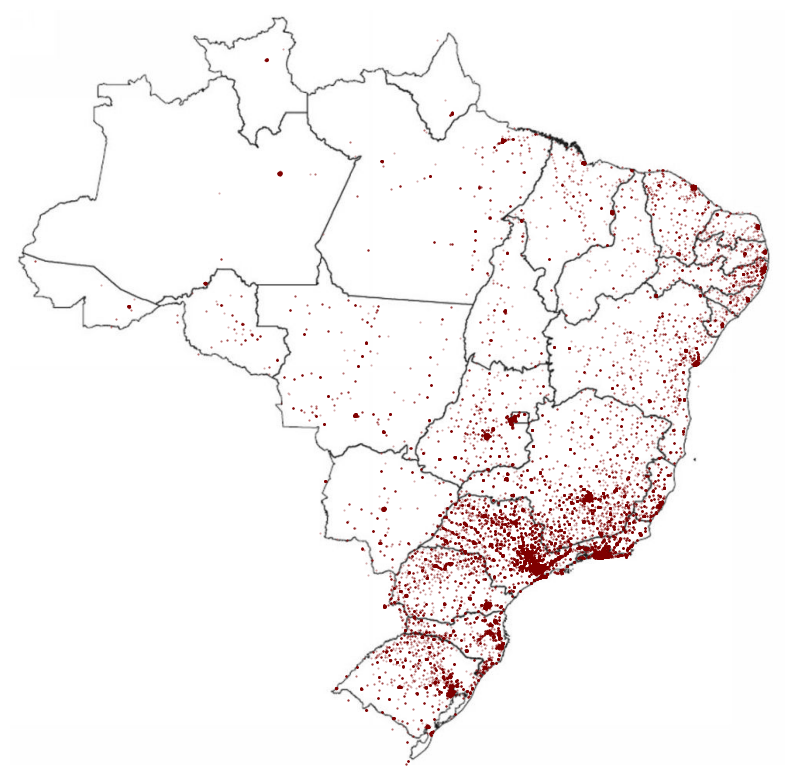

In [45]:
# Group by zip code prefix and state, then count unique occurrences
state_counts = data['geo'].groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='state_count')
state_counts = state_counts[state_counts['state_count'] >= 2]

# Identify maximum state occurrence by zip code prefix
max_state_info = data['geo'].groupby(['geolocation_zip_code_prefix', 'geolocation_state']).size().reset_index(name='state_count')
max_state_info = max_state_info.drop_duplicates(subset='geolocation_zip_code_prefix').drop('state_count', axis=1)

# Calculate median latitude and longitude by zip code, city, and state
geo_median = data['geo'].groupby(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])[['geolocation_lat', 'geolocation_lng']].median().reset_index()

# Merge the median coordinates with max state info
geo_data = geo_median.merge(max_state_info, on=['geolocation_zip_code_prefix', 'geolocation_state'], how='inner')

# Merge with customers data
customers_geo = customers_df.merge(geo_data, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

# Display the first 20 rows of the merged data
print(customers_geo.head(20))

# Drop duplicate orders
unique_customers = customers_geo.drop_duplicates('order_id')

# Save to CSV
unique_customers.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/geolocation.csv", index=False)

# Function to plot Brazil map with customer locations
def plot_brazil_map(data):
    brazil_img_url = 'https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'
    brazil_img = mpimg.imread(urllib.request.urlopen(brazil_img_url), 'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10, 10), alpha=0.3, s=0.3, color='maroon')
    plt.axis('off')
    plt.imshow(brazil_img, extent=[-73.98283055, -33.8, -33.75116944, 5.4])
    plt.show()

# Plot the map
plot_brazil_map(unique_customers.drop_duplicates(subset='customer_unique_id'))

## **Conclusion**


  > The company makes more money not by selling a high volume of products but by selling a variety of products, each priced between 50-500 R$ and with a low probability of selling.


  > Most products in the top 50 saw an increased likelihood of sales during Black Friday (BF). Top-performing products on Black Friday are highly rated (usually best sellers).

  > Based on the generated charts, there are more customers in the southeast and south regions. Additionally, customers are mostly found in major capital cities (São Paulo, Rio de Janeiro, Porto Alegre, and others).










